# Introduction

This is an example of using Luigi (https://luigi.readthedocs.io/en/stable/index.html) to create a data pipeline.  

This is intended to be an example of using Luigi to create a data pipeline that grabs data off the web (in this case building permits and ward boundaries for the city of Chicago) and does some data cleaning and visualization.

Cheers!

Dave

@imagingnerd

Github: dmwelch

Sources:

Excellent blog post by Sensitive Cities: http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html
Hunter Owens presentation at PyData Chicago 2016: https://github.com/hunterowens/data-pipelines

In [1]:
%matplotlib inline

import datetime
from datetime import date
import pickle
import StringIO
import zipfile

import luigi
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap  # pip install https://github.com/matplotlib/basemap/archive/v1.0.7rel.tar.gz
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
# from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

/Users/dwelch/virtualenvs/luigi/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Download permit data from the city of Chicago

We save the output to `data/permits.csv`

In [2]:
class DownloadData(luigi.ExternalTask):
    """
    Downloads permit data from city of Chicago
    """
    def run(self):
        url = 'https://data.cityofchicago.org/api/views/ydr8-5enu/rows.csv?accessType=DOWNLOAD'
        response = requests.get(url)
        with self.output().open('w') as out_file:
            out_file.write(response.text)

    def output(self):
        return luigi.LocalTarget("data/permits.csv")

## Clean the data

The `ESTIMATED_COST` column will create `Inf` values for "$" so we must clean the strings.

Save the cleaned data to `data/permits_clean.csv`

In [3]:
def to_float(s):
    default = np.nan
    try:
        r = float(s.replace('$', ''))
    except:
        return default
    return r
    
def to_int(s):
    default = None
    if s == '': return default
    return int(s)

def to_date(s):
    default = '01/01/1900'
    if s == '': s = default
    return datetime.datetime.strptime(s, "%m/%d/%Y")

# *** Additional available headers at the end ***
converter = {'ID': to_int,
             'PERMIT#': str,
             'PERMIT_TYPE': str,
             'ISSUE_DATE': to_date,
             'ESTIMATED_COST': to_float,
             'AMOUNT_WAIVED': to_float,
             'AMOUNT_PAID': to_float,
             'TOTAL_FEE': to_float,
             'STREET_NUMBER': to_int,
             'STREET DIRECTION': str,
             'STREET_NAME': str,
             'SUFFIX': str,
             'WORK_DESCRIPTION': str,
             'LATITUDE': to_float,
             'LONGITUDE': to_float,
             'LOCATION': str,
             }

class cleanCSV(luigi.Task):
    """This is our cleaning step"""

    def requires(self):
        return DownloadData()

    def run(self):
        df = pd.read_csv(self.input().open('r'), 
                         usecols=converter.keys(), 
                         converters=converter, 
                         skipinitialspace=True)
        df.to_csv(self.output().fn)

    def output(self):
        return luigi.LocalTarget("data/permits_clean.csv")

## Download the ward shapefiles

The response is in ZIP format, so we need to extract and return the `*.shp` file as the output

In [4]:
import shutil

class DownloadWards(luigi.ExternalTask):
    """
    Downloads ward shapefiles from city of Chicago
    """
    def run(self):
        url = "https://data.cityofchicago.org/api/geospatial/sp34-6z76?method=export&format=Shapefile"
        response = requests.get(url)
        z = zipfile.ZipFile(StringIO.StringIO(response.content))
        files = z.namelist()
        z.extractall('data/')
        for fname in files:
            shutil.move('data/' + fname, 'data/geo_export' + fname[-4:])

    def output(self):
        return luigi.LocalTarget("data/geo_export.shp")

### Convienence functions

In [5]:
def plot(m, ldn_points, df_map, bds, sizes, title, label, output):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)

    # we don't need to pass points to m() because we calculated using map_points and shapefile polygons
    dev = m.scatter(
        [geom.x for geom in ldn_points],
        [geom.y for geom in ldn_points],
        s=sizes, marker='.', lw=.25,
        facecolor='#33ccff', edgecolor='none',
        alpha=0.9, antialiased=True,
        label=label, zorder=3)
    # plot boroughs by adding the PatchCollection to the axes instance
    ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
    # copyright and source data info
    smallprint = ax.text(
        1.03, 0,
        'Total points: %s' % len(ldn_points),
        ha='right', va='bottom',
        size=4,
        color='#555555',
        transform=ax.transAxes)

    # Draw a map scale
    m.drawmapscale(
        bds[0] + 0.08, bds[1] + 0.015,
        bds[0], bds[1],
        10.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555',
        zorder=5)
    plt.title(title)
    plt.tight_layout()
    # this will set the image width to 722px at 100dpi
    fig.set_size_inches(7.22, 5.25)
    plt.savefig(output, dpi=500, alpha=True)
    # plt.show()

In [6]:
def make_basemap(infile):
    with fiona.open(infile) as shp:
        bds = shp.bounds
    extra = 0.05
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    w, h = bds[2] - bds[0], bds[3] - bds[1]
    # Check w & h calculations
    assert bds[0] + w == bds[2] and bds[1] + h == bds[3], "Width or height of image not correct!"
    center = (bds[0] + (w / 2.0), bds[1] + (h / 2.0))
    m = Basemap(projection='tmerc',
                lon_0=center[0],
                lat_0=center[1],
                ellps = 'WGS84',
                width=w * 100000 + 10000,
                height=h * 100000 + 10000,
                lat_ts=0,
                resolution='i',
                suppress_ticks=True
               )
    m.readshapefile(infile[:-4], 
                    'chicago', 
                    color='blue', 
                    zorder=3)
    # m.fillcontinents()
    return m, bds

def data_map(m):
    df_map = pd.DataFrame({'poly': [Polygon(xy) for xy in m.chicago],
                           'ward_name': [ward['ward'] for ward in m.chicago_info]})
    df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
    df_map['area_km'] = df_map['area_m'] / 100000
    # draw ward patches from polygons
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, fc='#555555',
                                                                  ec='#787878', lw=.25, alpha=.9,
                                                                  zorder=4))
    return df_map

def point_objs(m, df, df_map):
    # Create Point objects in map coordinates from dataframe lon and lat values
    map_points = pd.Series(
        [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['LONGITUDE'], df['LATITUDE'])])
    permit_points = MultiPoint(list(map_points.values))
    wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    return filter(wards_polygon.contains, permit_points)

## Map Permit Distribution

In [7]:
class MakePermitMap(luigi.Task):
    def requires(self):
        return dict(wards=DownloadWards(), 
                    data=cleanCSV())
    
    def run(self):
        m, bds = make_basemap(self.input()['wards'].fn)
        df = pd.read_csv(self.input()['data'].open('r'))
        df_map = data_map(m)
        ldn_points = point_objs(m, df, df_map)
        plot(m, ldn_points, df_map, bds, sizes=5, 
             title="Permit Locations, Chicago", 
             label="Permit Locations", 
             output='data/chicago_permits.png')

        
    def output(self):
        return luigi.LocalTarget('data/chicago_permits.png')

## Map Estimated Costs

In [8]:
class MakeEstimatedCostMap(luigi.Task):
    """ Plot the permits and scale the size by the estimated cost (relative to range)"""
    def requires(self):
        return dict(wards=DownloadWards(), 
                    data=cleanCSV())

    def run(self):
        m, bds = make_basemap(self.input()['wards'].fn)
        df = pd.read_csv(self.input()['data'].open('r'))
        # Get the estimated costs, normalize, and scale by 5 <-- optional
        costs = df['ESTIMATED_COST']
        costs.fillna(costs.min() * 2, inplace=True)
        assert not np.any([cost is np.inf for cost in costs]), "Inf in column!"
        # plt.hist(costs, 3000, log=True);
        sizes = ((costs - costs.min()) / (costs.max() - costs.min())) * 100  #scale factor
        
        df_map = data_map(m)
        ldn_points = point_objs(m, df, df_map)
        plot(m, ldn_points, df_map, bds, sizes=sizes, 
             title="Relative Estimated Permit Cost, Chicago", 
             label="Relative Estimated Permit Cost", 
             output='data/chicago_rel_est_cost.png')
        
    def output(self):
        return luigi.LocalTarget('data/chicago_est_cost.png')

## Run All Tasks

In [9]:
class MakeMaps(luigi.WrapperTask):
    """ RUN ALL THE PLOTS!!! """
    def requires(self):
        yield MakePermitMap()
        yield MakeEstimatedCostMap()
    
    def run(self):
        pass

Note: to run from the commandline:

1. Export to '.py' file
2. Run: 
    
    `python -m luigi chicago_permits MakeMaps --local-scheduler`

DEBUG: Checking if MakeMaps() is complete
DEBUG: Checking if MakePermitMap() is complete
DEBUG: Checking if MakeEstimatedCostMap() is complete
INFO: Informed scheduler that task   MakeMaps__99914b932b   has status   PENDING
DEBUG: Checking if cleanCSV() is complete
DEBUG: Checking if DownloadWards() is complete
INFO: Informed scheduler that task   MakeEstimatedCostMap__99914b932b   has status   PENDING
INFO: Informed scheduler that task   DownloadWards__99914b932b   has status   PENDING
DEBUG: Checking if DownloadData() is complete
INFO: Informed scheduler that task   cleanCSV__99914b932b   has status   PENDING
INFO: Informed scheduler that task   DownloadData__99914b932b   has status   PENDING
INFO: Informed scheduler that task   MakePermitMap__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 6
INFO: [pid 67254] Worker Worker(salt=497674608, workers=1, host=10-200-207-248.vlan9

False

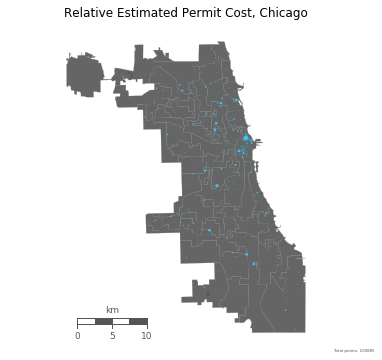

In [10]:
# if __name__ == '__main__':
luigi.run(['MakeMaps', '--local-scheduler'])

# Miscellaneous notes

The estimated cost spread is predictably non-linear, so further direction could be to filter out the "$0" as unestimated (which they likely are)!  

## Suggested work

* Map estimated costs overlaid with actual cost
* Map permits by # of contractors involved and cost
* Plot estimated cost accuracy based on contractor count
* Map permits by contractors
* Chloropleth maps by permit count, cost, etc.
* Include population density (Census data) or distance from major routes
* Etc...

In [ ]:
# For reference, cost spread is exponential
# plt.hist(costs, 3000, log=True);

In [ ]:
# Additional headers available...
"""
# PIN1,
# PIN2,
# PIN3,
# PIN4,
# PIN5,
# PIN6,
# PIN7,
# PIN8,
# PIN9,
# PIN10,
'CONTRACTOR_1_TYPE,
'CONTRACTOR_1_NAME,
'CONTRACTOR_1_ADDRESS,
'CONTRACTOR_1_CITY,
'CONTRACTOR_1_STATE,
'CONTRACTOR_1_ZIPCODE,
'CONTRACTOR_1_PHONE,
'CONTRACTOR_2_TYPE,
'CONTRACTOR_2_NAME,
'CONTRACTOR_2_ADDRESS,
'CONTRACTOR_2_CITY,
'CONTRACTOR_2_STATE,
'CONTRACTOR_2_ZIPCODE,
'CONTRACTOR_2_PHONE,
'CONTRACTOR_3_TYPE,
'CONTRACTOR_3_NAME,
'CONTRACTOR_3_ADDRESS,
'CONTRACTOR_3_CITY,
'CONTRACTOR_3_STATE,
'CONTRACTOR_3_ZIPCODE,
'CONTRACTOR_3_PHONE,
'CONTRACTOR_4_TYPE,
'CONTRACTOR_4_NAME,
'CONTRACTOR_4_ADDRESS,
'CONTRACTOR_4_CITY,
'CONTRACTOR_4_STATE,
'CONTRACTOR_4_ZIPCODE,
'CONTRACTOR_4_PHONE,
'CONTRACTOR_5_TYPE,
'CONTRACTOR_5_NAME,
'CONTRACTOR_5_ADDRESS,
'CONTRACTOR_5_CITY,
'CONTRACTOR_5_STATE,
'CONTRACTOR_5_ZIPCODE,
'CONTRACTOR_5_PHONE,
'CONTRACTOR_6_TYPE,
'CONTRACTOR_6_NAME,
'CONTRACTOR_6_ADDRESS,
'CONTRACTOR_6_CITY,
'CONTRACTOR_6_STATE,
'CONTRACTOR_6_ZIPCODE,
'CONTRACTOR_6_PHONE,
'CONTRACTOR_7_TYPE,
'CONTRACTOR_7_NAME,
'CONTRACTOR_7_ADDRESS,
'CONTRACTOR_7_CITY,
'CONTRACTOR_7_STATE,
'CONTRACTOR_7_ZIPCODE,
'CONTRACTOR_7_PHONE,
'CONTRACTOR_8_TYPE,
'CONTRACTOR_8_NAME,
'CONTRACTOR_8_ADDRESS,
'CONTRACTOR_8_CITY,
'CONTRACTOR_8_STATE,
'CONTRACTOR_8_ZIPCODE,
'CONTRACTOR_8_PHONE,
'CONTRACTOR_9_TYPE,
'CONTRACTOR_9_NAME,
'CONTRACTOR_9_ADDRESS,
'CONTRACTOR_9_CITY,
'CONTRACTOR_9_STATE,
'CONTRACTOR_9_ZIPCODE,
'CONTRACTOR_9_PHONE,
'CONTRACTOR_10_TYPE,
'CONTRACTOR_10_NAME,
'CONTRACTOR_10_ADDRESS,
'CONTRACTOR_10_CITY,
'CONTRACTOR_10_STATE,
'CONTRACTOR_10_ZIPCODE,
'CONTRACTOR_10_PHONE,
'CONTRACTOR_11_TYPE,
'CONTRACTOR_11_NAME,
'CONTRACTOR_11_ADDRESS,
'CONTRACTOR_11_CITY,
'CONTRACTOR_11_STATE,
'CONTRACTOR_11_ZIPCODE,
'CONTRACTOR_11_PHONE,
'CONTRACTOR_12_TYPE,
'CONTRACTOR_12_NAME,
'CONTRACTOR_12_ADDRESS,
'CONTRACTOR_12_CITY,
'CONTRACTOR_12_STATE,
'CONTRACTOR_12_ZIPCODE,
'CONTRACTOR_12_PHONE,
'CONTRACTOR_13_TYPE,
'CONTRACTOR_13_NAME,
'CONTRACTOR_13_ADDRESS,
'CONTRACTOR_13_CITY,
'CONTRACTOR_13_STATE,
'CONTRACTOR_13_ZIPCODE,
'CONTRACTOR_13_PHONE,
'CONTRACTOR_14_TYPE,
'CONTRACTOR_14_NAME,
'CONTRACTOR_14_ADDRESS,
'CONTRACTOR_14_CITY,
'CONTRACTOR_14_STATE,
'CONTRACTOR_14_ZIPCODE,
'CONTRACTOR_14_PHONE,
'CONTRACTOR_15_TYPE,
'CONTRACTOR_15_NAME,
'CONTRACTOR_15_ADDRESS,
'CONTRACTOR_15_CITY,
'CONTRACTOR_15_STATE,
'CONTRACTOR_15_ZIPCODE,
'CONTRACTOR_15_PHONE,
"""